In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import datetime
from cartopy import crs as ccrs, feature as cfeature
import matplotlib.patches as mpatches

import numpy as np
import os

## ADS-B TU Delft

In [9]:
date = 20170101

df = pd.read_csv('adsb_delft/csv/adsb_decoded_{}.csv'.format(date))
df.dropna(subset=["callsign"], inplace=True)
df.head()

,ts,icao,lat,lon,alt,spd,hdg,roc,callsign
3,1.483225e+09,406D94,53.26353,0.32280,35975,NaN,NaN,NaN,EZY49YZ_
6,1.483225e+09,48520B,51.37291,3.50060,27800,484.0,28.7,-3968.0,TRA667M_
9,1.483225e+09,44A833,50.11158,2.85578,27875,435.0,43.1,-1024.0,JAF1HD__
14,1.483225e+09,01010D,51.19922,1.27289,27025,472.0,96.4,1408.0,MSR780__
16,1.483225e+09,4BAA85,50.63855,3.90629,34950,452.0,109.5,0.0,THY9SU__


In [10]:
interval = 10 #min
duration = 12
duration *= 60

ts_start = df['ts'].iloc[0]
ts_end = ts_start + interval*60

visible_ac = []
mean_of_update_interval = []
time = []
all_update_interval = []

nb_data = int(duration/interval)

for i in range(nb_data):
    df_one_min = df[(df['ts'] >= ts_start) & (df['ts'] < ts_end)]
#     dt = datetime.fromtimestamp(df_one_min['ts'].iloc[-1])
#     print(dt)
    
    df_grouped = df_one_min.groupby('icao', group_keys=True).apply(lambda x: x)
    df_grouped['updateinterval'] = df_grouped['ts'].diff()
    df_grouped = df_grouped[(df_grouped['updateinterval'] > 0) & (df_grouped['updateinterval'] < 50)]
    ungrouped_df = df_grouped.reset_index(drop=True)
    
    ts_start = ts_end
    ts_end = ts_start + interval*60
    

In [11]:
ungrouped_df

,ts,icao,lat,lon,alt,spd,hdg,roc,callsign,updateinterval
0,1.483268e+09,020119,50.35346,3.62467,31400,427.0,208.2,1152.0,MAC122__,0.5
1,1.483268e+09,020119,50.34512,3.61775,31525,426.0,208.1,1344.0,MAC122__,4.7
2,1.483268e+09,020119,50.15556,3.46004,33075,423.0,208.0,832.0,MAC122__,5.4
3,1.483268e+09,020119,50.13757,3.44508,33250,422.0,208.1,1024.0,MAC122__,10.4
4,1.483268e+09,020119,49.70476,3.09020,35000,NaN,NaN,NaN,MAC122__,39.6
...,...,...,...,...,...,...,...,...,...,...
4844,1.483268e+09,E4818C,49.31023,4.63789,36000,NaN,NaN,NaN,TAM8070_,45.0
4845,1.483268e+09,E4818C,49.32431,4.68898,36000,510.0,67.1,0.0,TAM8070_,15.2
4846,1.483268e+09,E4818C,49.34271,4.75525,36000,NaN,NaN,NaN,TAM8070_,20.1
4847,1.483268e+09,E4818C,49.35505,4.79965,36000,NaN,NaN,NaN,TAM8070_,13.4


In [14]:
# example: draw circle with 1 degree radius around TU Delft
lat = 51.990122
lon = 4.375662
r = 3

# Define the projection used to display the circle:
proj = ccrs.Orthographic(central_longitude=lon, central_latitude=lat)


def compute_radius(ortho, radius_degrees):
    phi1 = lat + radius_degrees if lat <= 0 else lat - radius_degrees
    _, y1 = ortho.transform_point(lon, phi1, ccrs.PlateCarree())
    return abs(y1)

# Compute the required radius in projection native coordinates:
r_ortho = compute_radius(proj, r)

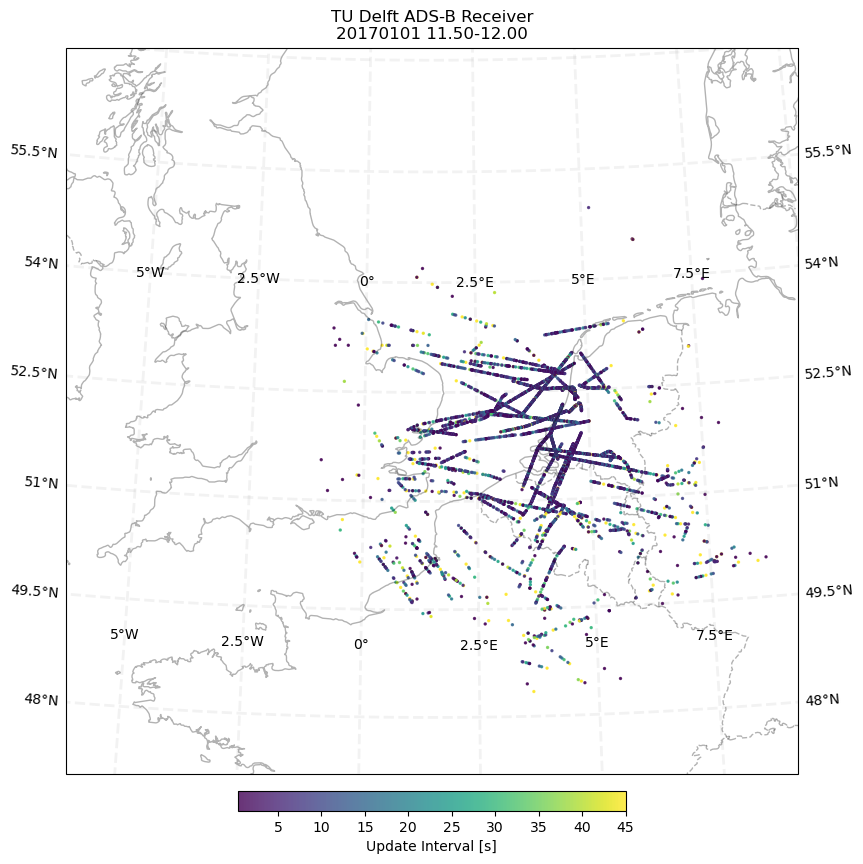

In [22]:
projPC = ccrs.PlateCarree()
lonW = -6
lonE = 9
latS = 47
latN = 57
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2
# res = '110m'

# Create the figure object
fig = plt.figure(
    figsize=(25, 25)
) 
projLccEur = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

icao = ungrouped_df["icao"].unique()

# Second subplot
ax = fig.add_subplot(2, 1, 2, projection=projLccEur)
ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
# ax2.set_facecolor(cfeature.COLORS['water'])
# ax2.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE, alpha = 0.3)
ax.add_feature(cfeature.BORDERS, linestyle='--', alpha = 0.3)

gl = ax.gridlines(
    draw_labels=True, linewidth=2, color='gray', alpha=0.1, linestyle='--'
)

for ic in icao:
    ac1 = ungrouped_df[ungrouped_df["icao"] == ic]
    lon_data = ac1['lon'].tolist()
    lat_data = ac1['lat'].tolist()
    up_data = ac1['updateinterval'].tolist()
    
    scatter = plt.scatter(lon_data, lat_data, c=up_data, cmap='viridis', s=2, alpha=0.8, transform=ccrs.PlateCarree())

cbar = plt.colorbar(scatter, label='Update Interval [s]', orientation = "horizontal", pad = 0.02, shrink = 0.2)
# ax.add_patch(mpatches.Circle(xy=[lon, lat], radius=r_ortho, color='red', alpha=0.3, transform=proj, zorder=30))
# fig.tight_layout()
    
ax.set_title('TU Delft ADS-B Receiver\n20170101 11.50-12.00');
# plt.show()

## OpenSky

In [23]:
from pyopensky import OpenskyImpalaWrapper
from datetime import datetime, timedelta

opensky = OpenskyImpalaWrapper()

time_col = "time"

serial = -1408237098

time_mid = '2022-01-01T00:00' #'%Y-%m-%dT%H:%M'
time_mid = datetime.strptime(time_mid, '%Y-%m-%dT%H:%M')
duration = 12 #hour
duration *= 60

series_opensky = pd.date_range(start=(time_mid).strftime('%Y-%m-%d %H:%M:%S'),
                                end=(time_mid + timedelta(minutes=duration)).strftime('%Y-%m-%d %H:%M:%S'), freq="10min").strftime('%Y-%m-%d %H:%M:%S')

print(series_opensky)

* Server connection successful!
Index(['2022-01-01 00:00:00', '2022-01-01 00:10:00', '2022-01-01 00:20:00',
       '2022-01-01 00:30:00', '2022-01-01 00:40:00', '2022-01-01 00:50:00',
       '2022-01-01 01:00:00', '2022-01-01 01:10:00', '2022-01-01 01:20:00',
       '2022-01-01 01:30:00', '2022-01-01 01:40:00', '2022-01-01 01:50:00',
       '2022-01-01 02:00:00', '2022-01-01 02:10:00', '2022-01-01 02:20:00',
       '2022-01-01 02:30:00', '2022-01-01 02:40:00', '2022-01-01 02:50:00',
       '2022-01-01 03:00:00', '2022-01-01 03:10:00', '2022-01-01 03:20:00',
       '2022-01-01 03:30:00', '2022-01-01 03:40:00', '2022-01-01 03:50:00',
       '2022-01-01 04:00:00', '2022-01-01 04:10:00', '2022-01-01 04:20:00',
       '2022-01-01 04:30:00', '2022-01-01 04:40:00', '2022-01-01 04:50:00',
       '2022-01-01 05:00:00', '2022-01-01 05:10:00', '2022-01-01 05:20:00',
       '2022-01-01 05:30:00', '2022-01-01 05:40:00', '2022-01-01 05:50:00',
       '2022-01-01 06:00:00', '2022-01-01 06:10:00', '20

In [24]:
ts_start = pd.Timestamp(series_opensky[-2], tz="utc").timestamp()
ts_end = pd.Timestamp(series_opensky[-1], tz="utc").timestamp()
hour_start = ts_start // 3600 * 3600
hour_end = (ts_end // 3600 + 1) * 3600

# print(ts_start, ts_end, hour_start, hour_end)

query = "SELECT * FROM state_vectors_data4, state_vectors_data4.serials s WHERE " 
# query += "lat<={} AND lat>={} AND lon<={} AND lon>={} ".format(lat1, lat2, lon1, lon2)
query += "hour>={} ".format(hour_start)
query += "AND hour<={} ".format(hour_end)
query += "AND {}>={} ".format(time_col, ts_start)
query += "AND {}<={} ".format(time_col, ts_end)
query += "AND s.ITEM = {}".format(serial)

print("Processing: {}/{}".format(i+1,(len(series_opensky) - 1)))
print(query)
#     df.append(opensky.rawquery(query));

df = opensky.rawquery(query)

if(df is not None):
    df.dropna(subset=["callsign"], inplace=True)
    df = df[df["onground"] == False]

    df_grouped = df.groupby('icao24', group_keys=True).apply(lambda x: x)
    df_grouped['updateinterval'] = df_grouped['lastposupdate'].diff()

    df_grouped = df_grouped[(df_grouped['updateinterval'] > 0) & (df_grouped['updateinterval'] < 50)]

    ungrouped_df = df_grouped.reset_index(drop=True)

print(df)

Processing: 72/72
SELECT * FROM state_vectors_data4, state_vectors_data4.serials s WHERE hour>=1641034800.0 AND hour<=1641042000.0 AND time>=1641037800.0 AND time<=1641038400.0 AND s.ITEM = -1408237098
* Fetching records...
Sending query request: [SELECT * FROM state_vectors_data4, state_vectors_data4.serials s WHERE hour>=1641034800.0 AND hour<=1641042000.0 AND time>=1641037800.0 AND time<=1641038400.0 AND s.ITEM = -1408237098]
Processing query result.
* Records downloaded.
              time  icao24        lat       lon    velocity     heading  \
122150  1641037800  4ca9d0  51.491896 -0.687637  173.429442  144.659893   
48439   1641037800  502cd7  52.570697  5.382987  129.676629  268.636072   
61967   1641037800  44ce61  51.060242  6.185377  159.594592  255.247037   
14906   1641037800  484164  51.364609  4.432241  208.816742  189.787204   
124393  1641037800  484f7f  55.196548  6.265842  232.530964  359.746481   
...            ...     ...        ...       ...         ...         ..

In [25]:
# example: draw circle with 1 degree radius around TU Delft
lat = 51.990122
lon = 4.375662
r = 4

# Define the projection used to display the circle:
proj = ccrs.Orthographic(central_longitude=lon, central_latitude=lat)


def compute_radius(ortho, radius_degrees):
    phi1 = lat + radius_degrees if lat <= 0 else lat - radius_degrees
    _, y1 = ortho.transform_point(lon, phi1, ccrs.PlateCarree())
    return abs(y1)

# Compute the required radius in projection native coordinates:
r_ortho = compute_radius(proj, r)

/Users/mfrahman/anaconda3/envs/traffic/lib/python3.10/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


/Users/mfrahman/anaconda3/envs/traffic/lib/python3.10/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)
/Users/mfrahman/anaconda3/envs/traffic/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/mfrahman/anaconda3/envs/traffic/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mfrahman/anaconda3/envs/traffic/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


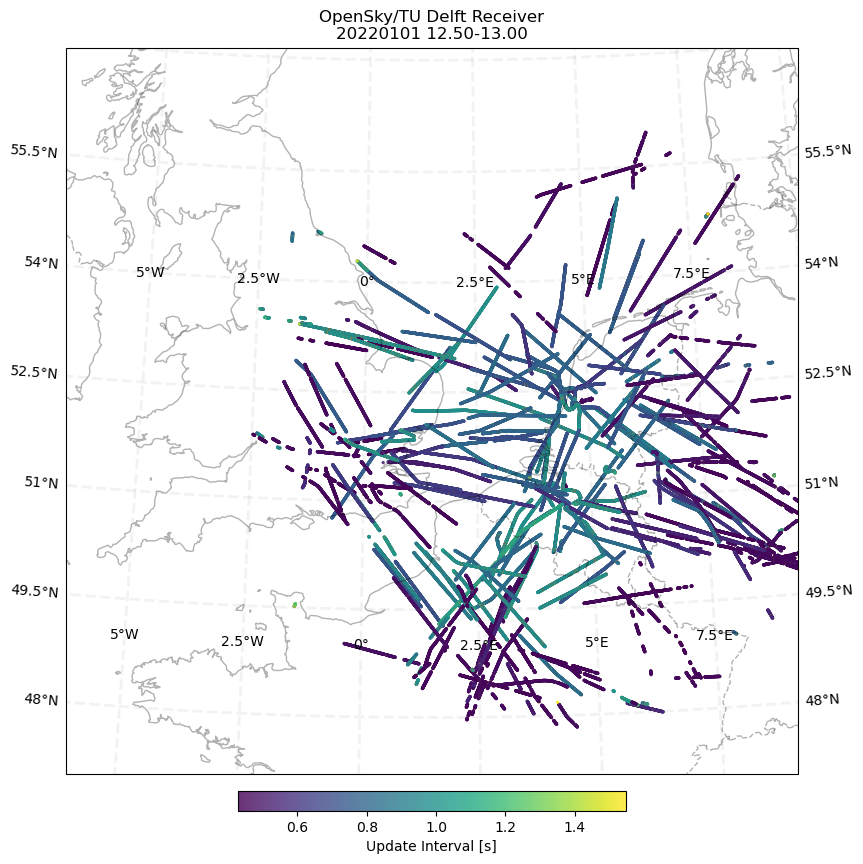

In [26]:
icao = ungrouped_df['icao24'].unique()

# Create the figure object
fig = plt.figure(
    figsize=(25, 25)
) 

projLccEur = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

# Second subplot
ax = fig.add_subplot(2, 1, 2, projection=projLccEur)
ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
# ax2.set_facecolor(cfeature.COLORS['water'])
# ax2.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE, alpha = 0.3)
ax.add_feature(cfeature.BORDERS, linestyle='--', alpha = 0.3)

gl = ax.gridlines(
    draw_labels=True, linewidth=2, color='gray', alpha=0.1, linestyle='--'
)

for ic in icao:
    ac1 = ungrouped_df[ungrouped_df["icao24"] == ic]
    lon_data = ac1['lon'].tolist()
    lat_data = ac1['lat'].tolist()
    up_data = ac1['updateinterval'].tolist()
    
    scatter = plt.scatter(lon_data, lat_data, c=up_data, cmap='viridis', s=2, alpha=0.8, transform=ccrs.PlateCarree())

cbar = plt.colorbar(scatter, label='Update Interval [s]', orientation = "horizontal", pad = 0.02, shrink = 0.2)
# ax.add_patch(mpatches.Circle(xy=[lon, lat], radius=r_ortho, color='red', alpha=0.3, transform=proj, zorder=30))
# fig.tight_layout()
    
ax.set_title('OpenSky/TU Delft Receiver\n20220101 12.50-13.00');

In [11]:
def categorize_update_interval(all_update_interval):
    result_dict = {}

    for num in all_update_interval:
        rounded_value = round(num, 1)
        if rounded_value not in result_dict:
            result_dict[rounded_value] = 0
        result_dict[rounded_value] += 1

    result_dict = dict(sorted(result_dict.items()))

    return result_dict